# Lexical particularities of Alorese

This notebook shows how to use LexiRumah to investigate the lexical differences between
two groups of languages in LexiRumah. As example, compare the lexicon of Alorese lects ([alor1247](http://glottolog.org/resource/languoid/id/alor1247)) with the lexicon of all other lects of Lamaholot ([lama1292](http://glottolog.org/resource/languoid/id/lama1292)) lects.

First we import a variety of necessary modules and define constants.

In [1]:
# Import generally useful modules
%matplotlib inline
from matplotlib import pyplot
import numpy
import itertools
from bisect import bisect
from collections import defaultdict, OrderedDict

In [2]:
# Import pylexirumah and related objects
from clldutils.path import Path
import pylexirumah
from pylexirumah.util import glottolog_clade, get_dataset, lexirumah_glottocodes

# Load the LexiRumah database
lexirumah = get_dataset()

We define the language groups: `alorese` will be all alorese lects in LexiRumah, `lamaholot` will contain all sedentary Lamaholot lects (spoken on Solor, Flores, Lembata etc., but not the Alorese lects of Alor and Pantar). In order to check for inheritance and cross-family borrowings, we define `an` and `tap` to be the groups of all other lects in the database, by family.

In [3]:
# This may take some time, our implementation of `glottolog_clade` is not built for speed.

alorese = glottolog_clade("alor1247")
print(alorese)

lamaholot = glottolog_clade("lama1292") - alorese
print(lamaholot)

floreslembata = glottolog_clade("flor1239") - alorese - lamaholot

an = glottolog_clade("aust1307") - alorese - lamaholot - floreslembata
tap = glottolog_clade("timo1261")

rest = set(lexirumah_glottocodes()) - alorese - lamaholot - floreslembata - an - tap

groups = [alorese, lamaholot, floreslembata, an, tap]

set()
{'lama1277-lewuk', 'alor1247-baran', 'lama1277-lewom', 'alor1247-munas', 'alor1247-pandai', 'lama1277-pukau', 'lama1277-ritae', 'lama1277-imulo', 'lama1277-belan', 'lama1277-kiwan', 'lama1277-lewoe', 'lama1277-merde', 'lama1277-lamat', 'lama1277-horow', 'lama1277-waiwa', 'lama1277-minga', 'lama1277-adona', 'lama1277-lerek', 'lama1277-lewog', 'lama1277-mulan', 'lama1277-paina', 'lama1277-dulhi', 'alor1247-besar', 'lama1277-lewoi', 'lama1277-lamah', 'lama1277-lewop', 'lama1277-tanju', 'lama1277-botun', 'lama1277-ileap', 'lama1277-bama', 'lama1277-lewot', 'lama1277-baipi', 'lama1277-lewok', 'lama1277-kalik', 'lama1277-lamak', 'lama1277-waiba', 'lama1277-lamal', 'lama1277-watan', 'lama1277-wuake', 'lama1277-lewob'}


The LexiRumah database contains a `CognateTable`, which associates forms with cognate classes. In principle, different sources can assign one form to different classes. This is not the case at the moment where all forms are automatically generated. Going forwards, it will be a useful assumption that the newer cognate judgements occur later in the file, which is the semantics the by the following code block takes into account.

Explicitly prioritizing or ignoring a specific source can still be done by adding a filtering `if` statement to the following `for` loop.

In [4]:
# Aggregate cognate data from the Form and Cognate table.

# First, load the relevant content of the CognateTable into memory as dictionary.
cognateclass_by_form = {}
for cognate in lexirumah["CognateTable"].iterdicts():
    cognateclass_by_form[cognate["Form_ID"]] = cognate["Cognateset_ID"]

# Then, generate a sequence of all cognate classes, storing associations from the
# cognate class ID to the set of (concept, lect, form) tuples representing all forms
# belonging to that class.
cognates_by_class = {}
for form in lexirumah["FormTable"].iterdicts():
    concept = form["Concept_ID"]
    lect = form["Lect_ID"]
    cognates_by_class.setdefault(
        cognateclass_by_form.get(form["ID"]), set()).add(
        (concept, lect, form["Form"]))

In order to compare the lexical material of the two language groups, we now check what cognate classes are attested in which of the language groups. For now, all cognate sets in LexiRumah are restricted to one concept each, which simplifies the following calculation and interpretation.

In [5]:
# attested_cognate_sets is a dictionary, which associates concepts to a list of sets.
# The list contains one set for each language group defined above, and the set is a
# set of all cognate set IDs that express that concept in at least one lect of that
# group.
attested_cognate_sets = defaultdict(lambda: [set() for g_ in groups])
for name, cognates in cognates_by_class.items():
    lects = {lect for (concept, lect, form) in cognates}
    concept, _, _ = next(iter(cognates))
    
    for g, group in enumerate(groups):
        if lects & group:
            attested_cognate_sets[concept][g].add(name)

Now we can compare the lexicon. Starting with the most ‘stable’ concepts (we don't have a direct measure of stability, but we can assume that concepts with fewer cognate classes are more stable), we list those concepts where Alorese and Lamaholot have different cognate classes.

In [6]:
# Sort concepts by stability, by running an insertion sort with the help of bisect.
concepts = []
concept_stability = []
for concept, concept_classes in attested_cognate_sets.items():
    order = len(
        set.union(*concept_classes))
    i = bisect(concept_stability, order)
    concepts.insert(i, concept)
    concept_stability.insert(i, order)
# concepts is now a list of concept IDs, in order of stability.

cognateset_pattern_counts = numpy.zeros((2,) * len(groups) + (len(concepts),))

# Count the number of cognate classes for each pattern.
for c, concept in enumerate(concepts):
    attested_in_groups = attested_cognate_sets[concept]

    for pattern in itertools.product([0, 1], repeat=len(groups)):
        cognate_classes_for_pattern = set.union(*attested_in_groups)
        for present, classes in zip(pattern, attested_in_groups):
            if present:
                cognate_classes_for_pattern &= classes
            else:
                cognate_classes_for_pattern -= classes
        
        cognateset_pattern_counts[pattern][c] = len(cognate_classes_for_pattern)

# Genome-style plots

Every vertical line in the following bar plots corresponds to a concept; stable concepts on the left, unstable concepts on the right. Inside each bar, different types of cognate classes are plotted – every cognate class attested in that group is plotted with the same percentage, with colors corresponding to the apparent origin of the form.

In [7]:
def genomestyle(group_index=None, order=None):
    # Prepare the figure
    pyplot.gcf().set_size_inches((14, 3))
    #pyplot.axis('off')
    #pyplot.gca().get_xaxis().set_visible(False)
    #pyplot.gca().get_yaxis().set_visible(False)

    # Only count cognate classes present in group `group_index` – set all counts where
    # `group_index` is absent to 0.
    counts = cognateset_pattern_counts.copy()
    if group_index is not None:
        counts.swapaxes(group_index, 0)[0] = 0

    # Where `normalize` is 0, no forms for that concept are given. Ignore.
    b = numpy.zeros((len(concepts), len(colorize)))
    
    for c, (color, cells) in enumerate(colorize.items()):
        bar_height = 0
        for cell in cells:
            bar_height = counts[cell] + bar_height
        b[:, c] = bar_height

    # This complex expression sorts the bars as we want them, but keeps the data
    # structure an array for easier calculations.
    order = order or sorted(
        range(len(b)),
        key=lambda x: tuple(
            sum(b[x][n:]) for n in range(len(b[x]))))
    sorted_bars = b[order]

    bottom = 0
    for color, bars in zip(colorize, sorted_bars.T):
        pyplot.bar(
            range(len(bars)),
            bars,
            1.0,
            bottom = bottom,
            color = color)
        bottom = bottom + bars
    
    pyplot.xlabel("Concept")
    pyplot.ylabel("Number of classes")
    return order

In [8]:
colorize = OrderedDict()

Some cognate classes are present in Alorese and other AN languages (including the provided reconstructions of pMP and pAN). If they follow the hierarchy (see below), we give them all the same orange color. (In addition, this color is given to all hierarchically inherited forms that did not make it into Alorese, but this is only for completion's sake.)

That is, all similarity classes found in every group for one of the following diagrams is colored orange.

    (TAP < ) AN       (TAP < ) AN                 (TAP < ) AN             (TAP < ) AN
                                \                           \                       \
                 FL             FL     FL                   FL        FL            FL
                                        \                    \         \             \
                    LH                  LH      LH           LH        LH            LH
                                                 \                      \             \
                                                 AL                     AL            AL



As an exception from that hierarchical inheritance color, Forms found in Alorese which are judged dissimilar to any other forms get the color purple marking them as “Alorese-specific”.

In [9]:
# Hierarchical inheritance
colorize[(1, 0.7, 0.2)] = [
    (1, 1, 1, 1, 1),
    (0, 1, 1, 1, 1),
    (0, 0, 1, 1, 1),
    (0, 0, 0, 1, 1),
    (1, 1, 1, 1, 0),
    (0, 1, 1, 1, 0),
    (0, 0, 1, 1, 0),
    (0, 0, 0, 1, 0),
    (1, 1, 1, 0, 0),
    (0, 1, 1, 0, 0), 
    (0, 0, 1, 0, 0),
    (1, 1, 0, 0, 0),
    (0, 1, 0, 0, 0)]

Similarity classes that are found in TAP, and outside TAP only in Alorese, are a priori easily explained as TAP loans, so they will all be colored green. (In the complete listing, that color is also chosen for all classes found in TAP, but not outside that family.)

In [10]:
# TAP forms
colorize[(0.0, 0.8, 0.0)] = [
     (1, 0, 0, 0, 1),
     (0, 0, 0, 0, 1)]
        

If a cognate class is attested in Alorese and other Flores-Lembata languages, but not in any Lamaholot dialect, that is slightly unexpected under the hypothesis that Alorese is a daughter, not a sister, of Lamaholot. We color those similarity classes in yellow.

Similarly, we assign the same yellow color to all classes that have an unexpected distribution. This includes
 1. All forms that “skipped” a clade in the inhertance hierarchy, eg. similarity classes found in AN, Alorese, and other Flores-Lembata languages, but not in any Lamaholot dialect;
 2. Similarity classes found in Timor-Alor-Pantar languages, but which in the Austronesian languages are found only in the wider Flores-Lembata languages.
 

In [11]:
# Unexpected distribution
colorize[(0.9, 0.9, 0.0)] = [
    (1, 0, 1, 1, 1),
    (1, 0, 1, 1, 0),
    (1, 0, 1, 0, 0),
    (1, 0, 0, 1, 1),
    (1, 1, 0, 1, 1),
    (0, 1, 0, 1, 1), 
    (1, 0, 0, 1, 0),
    (1, 1, 0, 1, 0),
    (0, 1, 0, 1, 0),
    (1, 1, 1, 0, 1),
    (0, 1, 1, 0, 1),
    (0, 0, 1, 0, 1),
    (1, 1, 0, 0, 1),
    (0, 1, 0, 0, 1),
    (1, 0, 1, 0, 1)]


In [12]:
# Alorese forms
colorize[(0.8, 0.1, 1.0)] = [
    (1, 0, 0, 0, 0)]

In [13]:
# This should be all combinations.
all_patterns = [(0,) * len(groups)]
for patterns in colorize.values():
    all_patterns.extend(patterns)
for i, j in zip(sorted(all_patterns), sorted(itertools.product([0, 1], repeat=len(groups)))):
    if i!=j:
        print("expected:", j, "but found:", i)

# Genome-style plot of the entire database
The plots below sort concepts by their local stability. If you want a specific order, eg. order by global stability, you have to calculate that order and pass it to those plotting functions as argument. Here, the output is the distribution of these classes over the entire database.

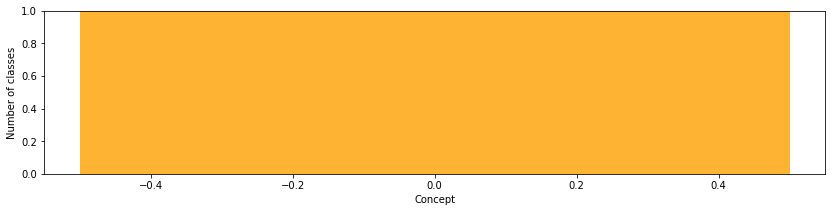

In [14]:
order = genomestyle(None, order=None)

## TAP forms

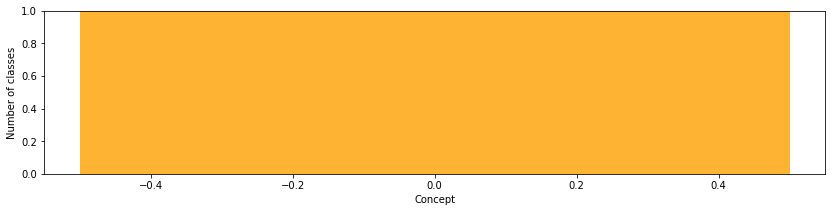

In [15]:
_ = genomestyle(4, order=None)

## Alorese forms

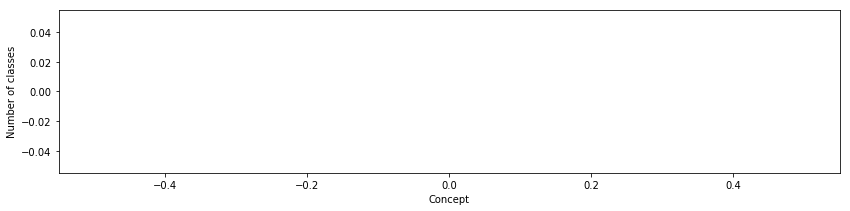

In [16]:
_ = genomestyle(0, order=None)

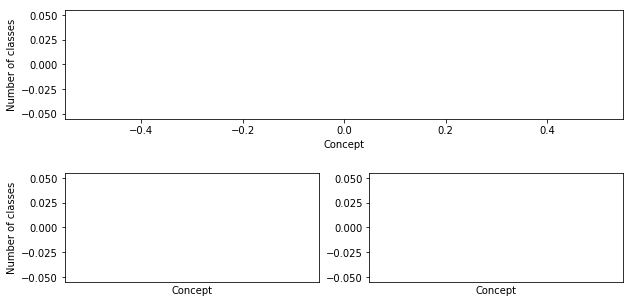

In [17]:
pyplot.subplot2grid((2, 2), (0, 0), colspan=2)

_ = genomestyle(0, order=order)

concepts_in_order = [concepts[o] for o in order]

pyplot.subplot2grid((2, 2), (1, 0))
_ = genomestyle(0, order=order)
pyplot.xticks(range(len(concepts)), concepts_in_order, rotation='vertical')
pyplot.xlim(19.5, 40.5)

pyplot.subplot2grid((2, 2), (1, 1))
_ = genomestyle(0, order=order)
pyplot.xticks(range(len(concepts)), concepts_in_order, rotation='vertical')
pyplot.xlim(529.5, 550.5)
pyplot.ylabel("")

pyplot.gcf().set_size_inches((10, 5))
pyplot.subplots_adjust(hspace=0.5)

pyplot.savefig("Fig7.eps", format='eps', dpi=600)

(19.5, 80.5)

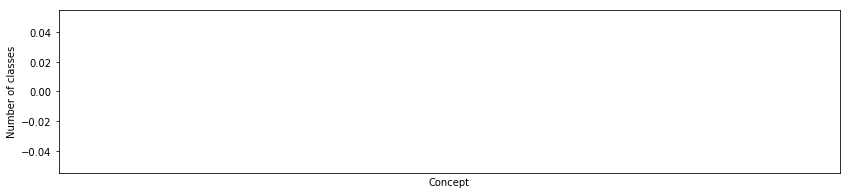

In [18]:
_ = genomestyle(0, order=order)
pyplot.xticks(range(len(concepts)), concepts_in_order, rotation='vertical')
pyplot.xlim(19.5, 80.5)

## Examples: a few of the concepts seen in the figures above

In [19]:
for c in attested_cognate_sets["lizard"][0]:
    for group, lects in zip(("AL", "LH", "FL", "AN", "TAP"), groups):
        print(group)
        for concept, lect, form in cognates_by_class[c]:
            if lect in lects:
                print(lect, form)


In [20]:
for c in attested_cognate_sets["thirteen"][0]:
    for group, lects in zip(("AL", "LH", "FL", "AN", "TAP"), groups):
        print(group)
        for concept, lect, form in cognates_by_class[c]:
            if lect in lects:
                print(lect, form)


In [21]:
for c in attested_cognate_sets["tongue"][0]:
    for group, lects in zip(("AL", "LH", "FL", "AN", "TAP"), groups):
        print(group)
        for concept, lect, form in cognates_by_class[c]:
            if lect in lects:
                print(lect, form)


In [22]:
for c in attested_cognate_sets["church"][0]:
    for group, lects in zip(("AL", "LH", "FL", "AN", "TAP"), groups):
        print(group)
        for concept, lect, form in cognates_by_class[c]:
            if lect in lects:
                print(lect, form)


In [23]:
for c in attested_cognate_sets["claw"][0]:
    for group, lects in zip(("AL", "LH", "FL", "AN", "TAP"), groups):
        print(group)
        for concept, lect, form in cognates_by_class[c]:
            if lect in lects:
                print(lect, form)
    print()

print()
print("For context, the forms in Lamaholot:")
for c in attested_cognate_sets["claw"][1]:
    for group, lects in zip(("AL", "LH", "FL", "AN", "TAP"), groups):
        print(group)
        for concept, lect, form in cognates_by_class[c]:
            if lect in lects:
                print(lect, form)


For context, the forms in Lamaholot:


In [24]:
for concept in concepts:
    by_group = attested_cognate_sets[concept]
    if by_group[0] != by_group[1]:
        if by_group[0] and by_group[1]:
            fl_skipping_l = (by_group[0] & by_group[2]) - by_group[1]
            an_skipping_l = (by_group[0] & by_group[3]) - by_group[1]
            skipping = fl_skipping_l | an_skipping_l
            a_but_not_l = by_group[0] - by_group[1]
            l_skipping_a = by_group[1] - by_group[0]

            print("Concept ‘{:}’ is different between Alorese and Lamaholot.".format(
                concept))
            print()
            if (a_but_not_l - skipping) - by_group[4]:
                print("", "Alorese innovated the following forms:")
                for cognateclass in a_but_not_l - skipping:
                    print("", cognates_by_class[cognateclass])
            if (a_but_not_l - skipping) & by_group[4]:
                print("", "Alorese shares the following forms with TAP languages:")
                for cognateclass in a_but_not_l - skipping:
                    print("", cognates_by_class[cognateclass])
            if skipping:
                print("", "Alorese shares the following forms with other AN languanges, but not Lamaholot:")
                for cognateclass in skipping:
                    print("", cognates_by_class[cognateclass])
            if l_skipping_a:
                print("", "One or more Lamaholot dialects innovated forms not found in Alorese:")
                for cognateclass in l_skipping_a:
                    print("", cognates_by_class[cognateclass])
            if by_group[1] & by_group[0]:
                print()
                print(" ", "Just for clarity:")
                print(" ", "There are also the following similarity classes shared between Alorese and LH.")
                for cognateclass in by_group[1] & by_group[0]:
                    print(" ", cognates_by_class[cognateclass])
        elif by_group[0]:
            print("Concept {:} is attested only in Alorese".format(concept))
        elif by_group[1]:
            print("Concept {:} is attested only in Lamaholot".format(concept))
        print("\n\n")
        


Concept nine is attested only in Lamaholot



